# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract. The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`.

To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [2]:
#from arxiv_scraper import cat_scrape
#cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [3]:
file_name = "arxiv_sample_1000"

We start by importing all the packages we will need and setting up a data directory.

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # regular expressions
import pickle # enables saving data and models locally
import spacy as sp # used for lemmatising text
import wget # downloading files
import tarfile # dealing with compressed .tar.gz files

os.system("mkdir data") # create data directory

print("Packages loaded and data directory created.")

Packages loaded and data directory created.


<h2> Fetching data </h2>

We then download the chosen data set --- if you've already scraped your own data set then skip this stage.

In [5]:
url_start = f"https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/scholarly_data/"

# download the paper data
if not os.path.isfile(f'data/{file_name}.csv'):
    print(f"Downloading {file_name}.csv...", end = " ")
    wget.download(url_start + f"{file_name}.csv", out = f"data/{file_name}.csv")
    print("Done!")
else:
    print(f"{file_name}.csv already downloaded.")

arxiv_sample_1000.csv already downloaded.


Next, we download a list of all the arXiv categories and store them in `cats`.

In [6]:
# download a list of all the arXiv categories
if not os.path.isfile('data/cats.csv'):
    print("Downloading cats.csv...", end = " ")
    wget.download(url_start + "cats.csv", out = "data/cats.csv")
    print("Done!")
else:
    print("cats.csv already downloaded.")

# construct category dataframe and array
cats_df = pd.read_csv("data/cats.csv")
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

cats.csv already downloaded.


,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


Next up we load the data into a dataframe. This might take a little while.

In [7]:
def nan_if_empty(x):
    ''' Converts empty lists/arrays to NaNs, making it easier to detect by pandas. '''
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    else:
        return arr

def remove_non_cats(x):
    ''' Removes every string in x which does not occur in the list of arXiv categories. '''
    return np.intersect1d(np.asarray(x), cats)

def str_to_arr(x):
    ''' Converts a string to a numpy array. '''
    return np.asarray(re.sub('[\' \[\]]', '', x).split(','))

def clean_cats(x):
    ''' Composition of nan_if_empty, remove_non_cats and str_to_arr. Used to clean scraped data. '''
    return nan_if_empty(remove_non_cats(str_to_arr(x)))

In [8]:
# set up dataframe
df = pd.read_csv(f'data/{file_name}.csv', converters={'category': clean_cats})[['title', 'abstract', 'category']]

print(f"Loaded metadata from {df.shape[0]} papers. Here are some of them:")
pd.set_option('display.max_colwidth', 300)
df.sample(3)

Loaded metadata from 1000 papers. Here are some of them:


,title,abstract,category
999,A Complete Enumeration and Classification of Two-Locus Disease Models,"There are 512 two-locus, two-allele, two-phenotype, fully-penetrant disease\nmodels. Using the permutation between two alleles, between two loci, and\nbetween being affected and unaffected, one model can be considered to be\nequivalent to another model under the corresponding permutation. Thes...","[nlin.AO, q-bio.PE]"
978,Rapidly Rotating Bose-Einstein Condensates in Homogeneous Traps,"We extend the results of a previous paper on the Gross-Pitaevskii description\nof rotating Bose-Einstein condensates in two-dimensional traps to confining\npotentials of the form V(r) = r^s, $2<s <\infty$. Writing the coupling constant\nas $1/\epsilon^2$ we study the limit $\epsilon \to 0$. We...","[cond-mat.other, cond-mat.stat-mech, math-ph, math.MP]"
920,Quantum transport in high-quality shallow InSb quantum wells,"InSb is one of the promising candidates to realize a topological state\nthrough proximity induced superconductivity in a material with strong\nspin-orbit interactions. In two-dimensional systems, thin barriers are needed\nto allow strong coupling between superconductors and semiconductors. How...",[cond-mat.mes-hall]


<h2> Cleaning the data </h2>

We next do some basic cleaning of the data.

In [9]:
df_clean = df.copy()

# drop rows with NaNs
df_clean.dropna(inplace=True)

# merge title and abstract
df_clean['clean_text'] = df_clean['title'] + ' ' + df_clean['abstract']

# remove punctuation marks
punctuation ='\!\"\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~'
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x: re.sub(punctuation, '', x))

# convert text to lowercase
df_clean['clean_text'] = df_clean['clean_text'].str.lower()

# remove numbers
df_clean['clean_text'] = df_clean['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x:' '.join(x.split()))

pd.set_option('display.max_colwidth', 300)
df_clean[['title', 'abstract', 'clean_text']].sample(3)

,title,abstract,clean_text
428,Revisiting elliptical satellite orbits to enhance the O3b constellation,"We propose an addition of known elliptical orbits to the new equatorial O3b\nsatellite constellation, extending O3b to cover high latitudes and the Earth's\npoles. We simulate the O3b constellation and compare this to recent measurement\nof the first real Internet traffic across the newly depl...","revisiting elliptical satellite orbits to enhance the o b constellation we propose an addition of known elliptical orbits to the new equatorial o b satellite constellation, extending o b to cover high latitudes and the earth's poles. we simulate the o b constellation and compare this to recent m..."
973,A Nekrasov-Okounkov formula for Macdonald polynomials,We prove a Macdonald polynomial analogue of the celebrated Nekrasov-Okounkov\nhook-length formula from the theory of random partitions. As an application we\nobtain a proof of one of the main conjectures of Hausel and Rodriguez-Villegas\nfrom their work on mixed Hodge polynomials of the moduli...,a nekrasov-okounkov formula for macdonald polynomials we prove a macdonald polynomial analogue of the celebrated nekrasov-okounkov hook-length formula from the theory of random partitions. as an application we obtain a proof of one of the main conjectures of hausel and rodriguez-villegas from th...
945,Quantum hardware simulating four-dimensional inelastic neutron\n scattering,"Finite-size spin systems could constitute key elements in future spintronics\ndevices [1-5], long-lasting nano-scale memories [6] or scalable and\nnoise-resilient quantum computing platforms [7-9]. They are also natural\ntest-beds for investigating peculiar quantum phenomena [10]. Inelastic Ne...","quantum hardware simulating four-dimensional inelastic neutron scattering finite-size spin systems could constitute key elements in future spintronics devices [ - ], long-lasting nano-scale memories [ ] or scalable and noise-resilient quantum computing platforms [ - ]. they are also natural test..."


Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a while to finish, so instead we're simply going to download a lemmatised version of your chosen data set. Alternatively, if you're dealing with your own scraped data set, you can uncomment the marked lines below.

In [10]:
def lemmatise(texts):
    ''' Lemmatise an iterable of strings. '''
    
    # import spacy's language model
    try:
        nlp = sp.load('en', disable=['parser', 'ner'])
    except:
        os.system("python -m spacy download en --user")
        nlp = sp.load('en', disable=['parser', 'ner']) 

    return np.asarray([' '.join(np.asarray([token.lemma_ for token in nlp(text)])) for text in texts])

In [11]:
df_lemm = df_clean.copy()

if not os.path.isfile(f"data/{file_name}_clean.csv"):
    
    #  uncomment if you want to do it the hard way, or if you're dealing with your own data set
    #df_lemm['clean_text'] = lemmatise(df_lemm['clean_text'])
    #df_lemm.to_csv(f"data/{file_name}_clean.csv")
    #print(f"Finished lemmatising, and also saved lemmatised dataframe to data/{file_name}_clean.csv.")
    
    # download lemmatised dataframe
    print(f"Downloading {file_name}_clean.csv...", end = " ")
    wget.download(url_start + f"{file_name}_clean.csv", out = f"data/{file_name}_clean.csv")
    print("Done!")
    
# load lemmatised dataframe
df_clean['clean_text'] = pd.read_csv(f"data/{file_name}_clean.csv")
print(f"Loaded lemmatised data from data/{file_name}_clean.csv.")

pd.set_option('display.max_colwidth', 300)
df_lemm.sample(3)

Loaded lemmatised data from data/arxiv_sample_1000_clean.csv.


,title,abstract,category,clean_text
367,"First-principles study of the inversion thermodynamics and electronic\n structure of Fe$M_2X_4$ (thio)spinels ($M=$ Cr, Mn, Co, Ni; $X=$ O, S)","Fe$M_2X_4$ spinels, where $M$ is a transition metal and $X$ is oxygen or\nsulfur, are candidate materials for spin filters, one of the key devices in\nspintronics. We present here a computational study of the inversion\nthermodynamics and the electronic structure of these (thio)spinels for $M=...","[cond-mat.mtrl-sci, cond-mat.str-el, physics.chem-ph, physics.comp-ph]","first-principles study of the inversion thermodynamics and electronic structure of fe$m_ x_ $ (thio)spinels ($m=$ cr, mn, co, ni; $x=$ o, s) fe$m_ x_ $ spinels, where $m$ is a transition metal and $x$ is oxygen or sulfur, are candidate materials for spin filters, one of the key devices in spintr..."
832,Parameter estimation for a subcritical affine two factor model,"For an affine two factor model, we study the asymptotic properties of the\nmaximum likelihood and least squares estimators of some appearing parameters in\nthe so-called subcritical (ergodic) case based on continuous time observations.\nWe prove strong consistency and asymptotic normality of t...","[math.ST, q-fin.ST, stat.TH]","parameter estimation for a subcritical affine two factor model for an affine two factor model, we study the asymptotic properties of the maximum likelihood and least squares estimators of some appearing parameters in the so-called subcritical (ergodic) case based on continuous time observations...."
174,Optimization of linear and nonlinear interaction schemes for stable\n synchronization of weakly coupled limit-cycle oscillators,"Optimization of mutual synchronization between a pair of limit-cycle\noscillators with weak symmetric coupling is considered in the framework of the\nphase reduction theory. By generalizing a previous study on the optimization of\ncross-diffusion coupling matrices between the oscillators, we c...",[nlin.AO],optimization of linear and nonlinear interaction schemes for stable synchronization of weakly coupled limit-cycle oscillators optimization of mutual synchronization between a pair of limit-cycle oscillators with weak symmetric coupling is considered in the framework of the phase reduction theory...


## One-hot encoding of categories

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [12]:
def cats_to_binary(categories):
    '''
    Turns categories into a 0-1 sequence with 1's at every category index.
    
    INPUT
        categories, an iterable of strings
    
    OUTPUT
        numpy array with 1 at the category indexes and zeros everywhere else
    '''
    return np.in1d(cats, categories).astype('int8')

print("One-hot encoding...", end = " ")

df_1hot = df_clean.copy()

# populate cats_df with the information from df
bincat_arr = np.array([cats_to_binary(cat_list) for cat_list in df_1hot['category']]).transpose()
bincat_dict = {key:value for (key,value) in zip(cats, bincat_arr)}
bincat_df = pd.DataFrame.from_dict(bincat_dict)

# concatenate df with the columns in cats_df
df_1hot = pd.concat([df_1hot, bincat_df], axis=1, sort=False)

# drop the category column
df_1hot.drop(['category'], axis=1, inplace=True)

print("Done!")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
print(f"Dimensions of df_1hot: {df_1hot.shape}.")
df_1hot.head()

One-hot encoding... Done!
Dimensions of df_1hot: (1000, 156).


,title,abstract,clean_text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,On inv...,In t...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,On a p...,A th...,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Restri...,In t...,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Counti...,We c...,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Curren...,We p...,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Analysis of the data </h2>

Here is how the categories in our data set are distributed.

In [13]:
# save a dataframe with the amount of papers in each category
sum_cats = bincat_df.apply(lambda x: x.sum())

# get statistical information about the distribution of the amount of papers
sum_cats.describe()

count    153.00...
mean     14.450980
std      11.656792
min       0.000000
25%       5.000000
50%      12.000000
75%      20.000000
max      55.000000
dtype: float64

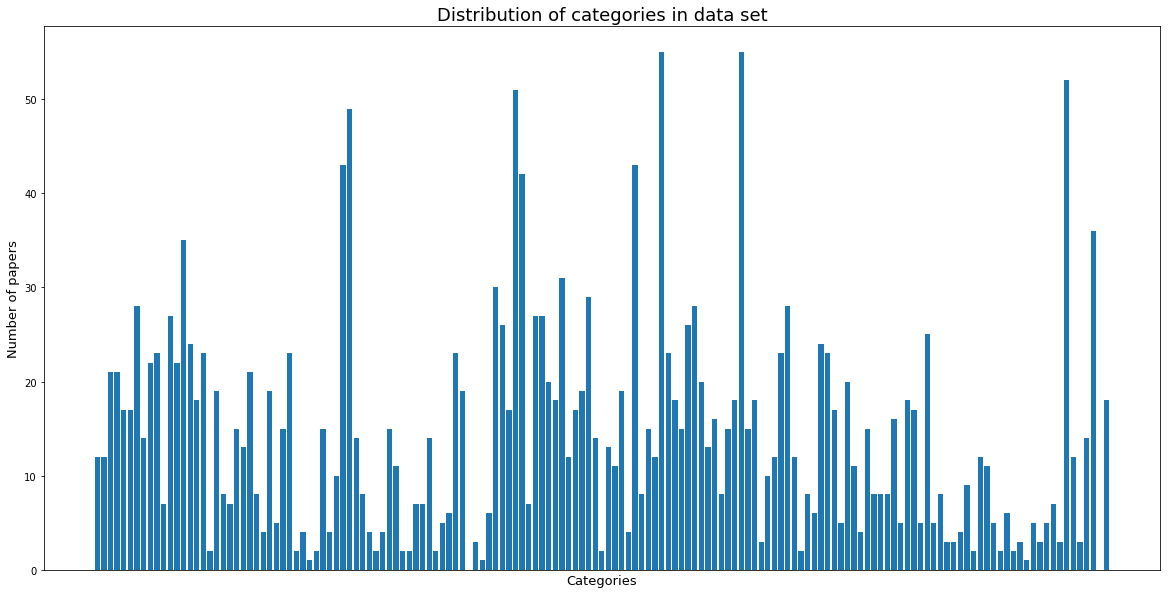

In [14]:
# plot the distribution of the amount of papers in each category
plt.figure(figsize=(20,10))
plt.bar(x=sum_cats.keys(), height=sum_cats.values)
plt.xlabel('Categories', fontsize=13)
plt.ylabel('Number of papers', fontsize=13)
plt.title('Distribution of categories in data set', fontsize=18)
plt.xticks([])
plt.show()

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

In [15]:
# add the counts to the dataframe and sort 
cats_df['count'] = sum_cats.values
cats_df = cats_df.sort_values(by=['count'], ascending=False)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

,category,description,count
85,math.MP,Mathematical Physics,55
97,math-ph,Mathematical Physics,55
146,quant-ph,Quantum Physics,52
63,hep-ph,High Energy Physics - Phenomenology,51
38,cs.LG,Learning,49


<h2> ELMo feature extraction </h2>

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will need the following extra packages.

Next, we download the ELMo model. It is over 350mb in size, so it might take a little while.

In [16]:
if not os.path.isdir("elmo"):
    # download ELMo model
    print("Downloading compressed ELMo model...", end = " ")
    url = "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed"
    wget.download(url, out="elmo.tar.gz")
    print("Done!")

    # uncompress ELMo model
    print("Uncompressing into the 'elmo' directory...", end = " ")
    os.system("mkdir elmo") # create directory
    with tarfile.open("elmo.tar.gz") as tar:
        tar.extractall("elmo")
    os.remove("elmo.tar.gz")
    print("Done!")
else:
    print("The 'elmo' directory already exists, so assuming that the model has been downloaded.")

The 'elmo' directory already exists, so assuming that the model has been downloaded.


We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

In [17]:
from elmo import extract

if not os.path.isfile(f"data/{file_name}_elmo.pickle"):
    # extract ELMo data
    elmo_data = extract(
        df_1hot['clean_text'], 
        batch_size = 10 # lower batch size gives less accurate vectors but requires less RAM
    )

    # save ELMo data
    with open(f"data/{file_name}_elmo.pickle", "wb") as pickle_out:
        pickle.dump(elmo_data, pickle_out)

    print(f"ELMo extraction completed. Also saved elmo data to data/{file_name}.elmo.pickle.")
else:
    # load ELMo data
    with open(f"data/{file_name}_elmo.pickle", "rb") as pickle_in:
        elmo_data = pickle.load(pickle_in)

    print(f"ELMo data loaded from data/{file_name}_elmo.pickle.")

print(f"Dimensions of elmo_data: {elmo_data.shape}")

df_elmo = pd.DataFrame(elmo_data)
df_elmo = df_elmo.join(pd.DataFrame(df_1hot.drop(columns=['title', 'abstract', 'clean_text'])))

print(f"Dimensions of df_elmo: {df_elmo.shape}")

df_elmo.head()

W0601 19:37:23.960631 139786319603520 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


ELMo data loaded from data/arxiv_sample_1000_elmo.pickle.
Dimensions of elmo_data: (989, 1024)
Dimensions of df_elmo: (989, 1177)


,0,1,2,3,4,5,6,7,8,9,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,0.010670,0.036672,0.012926,-0.032160,0.034860,0.032115,-0.036730,0.194203,0.022366,-0.146691,...,0,0,0,0,0,0,0,0,0,0
1,0.068165,0.125065,0.061963,-0.089762,0.018734,-0.072867,-0.000450,0.247011,0.005538,-0.183312,...,0,0,0,0,0,0,0,0,0,0
2,-0.017157,0.089970,-0.017110,0.020730,0.048162,-0.075034,-0.031217,0.063156,0.081665,-0.158918,...,0,0,0,0,0,0,0,0,0,0
3,0.185463,0.190429,-0.036074,-0.009252,0.125236,0.010753,-0.098363,0.250005,0.133494,-0.167484,...,0,0,0,0,0,0,0,0,0,0
4,0.009185,-0.001601,0.014676,-0.009795,0.012431,-0.048619,-0.014964,0.011422,-0.033436,-0.129378,...,0,0,0,0,0,0,0,0,0,0


In [85]:
from sklearn.decomposition import PCA
import seaborn as sns

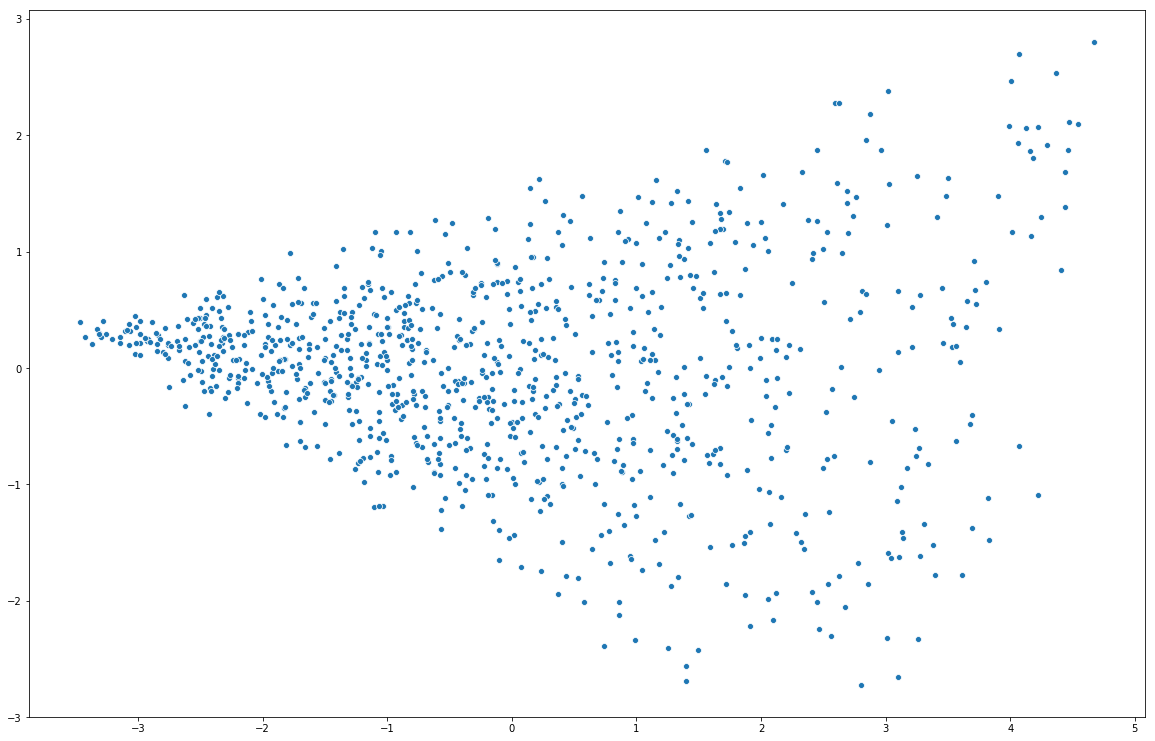

In [112]:
pca = PCA(n_components = 2)
X_2d = pca.fit_transform(X)

fig, ax = plt.subplots(1, figsize = (20, 13))

sns.scatterplot(x = X_2d[:, 0], y = X_2d[:, 1])

## Choosing a model

We are now done manipulating our data, and the time has come to build a model.

In [45]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import hamming_loss, make_scorer

In [40]:
X = np.asarray(df_elmo.iloc[:, 0:1024])
Y = np.asarray(df_elmo.iloc[:, 1024:])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [79]:
def micro_avg_recall(Y_test, Y_hat):
    TPs = np.sum(Y_hat.multiply(Y_test).todense())
    return TPs / np.sum(Y_test)

micro_avg_recall_scorer = make_scorer(micro_avg_recall)

In [80]:
clf = MLkNN(k = 3)
clf.fit(X_train, Y_train)
Y_hat = clf.predict(X_test)

print(f"Microaveraging recall score: {micro_avg_recall(Y_test, Y_hat)}")

Microaveraging recall score: 0.003738317757009346


In [81]:
parameters = {'k': range(1,5), 's': [0.5, 0.75, 1.0]}

grid_search = GridSearchCV(MLkNN(), parameters, scoring = micro_avg_recall_scorer, cv = 10)
grid_search.fit(X, Y)

print(f"The best parameters are {grid_search.best_params_}")
print(f"The best score was {grid_search.best_score_}.")

The best parameters are {'k': 1, 's': 0.5}
The best score was 0.018937468538278955.


In [ ]:
print(f"The best parameters are {grid_search.best_params_}")
print(f"The best score was {grid_search.best_score_}.")

In [ ]:
clf = grid_search.best_estimator_

with open("model.pickle") as pickle_in:
    pickle.dump(clf, pickle_in)